In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50


In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"potato-dieses",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


In [7]:
# visualise image

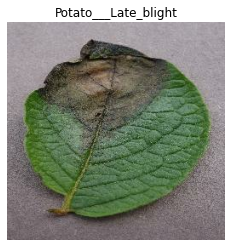

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
    

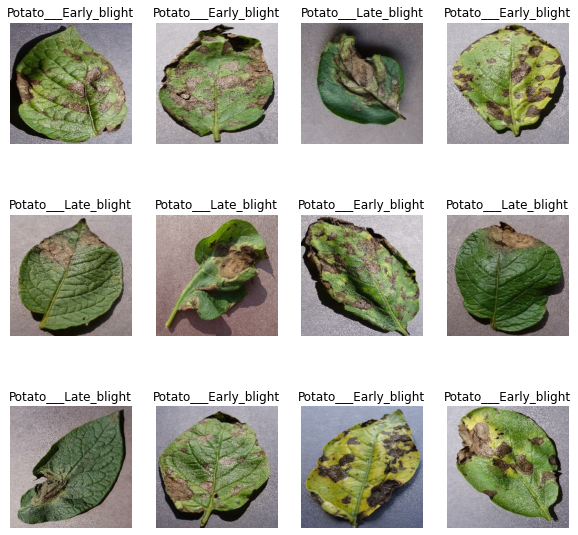

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [10]:
len(dataset)

68

In [11]:
# 80% = training
# 20% = 10% for validation, 10% for test

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
# train dataset
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
   
    ds_size= len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
# cache = read the image from disk and for next iteration it will keep in memory, it increase the performance
# prefetch = improve the performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
# data augmentation to make our model robust

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])


In [26]:
# model building

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=input_shape)

In [27]:
model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [29]:
model.compile(
optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
train_ds,
epochs = EPOCHS,
batch_size = BATCH_SIZE,
verbose = 1,
validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 132s 2s/step - loss: 0.9046 - accuracy: 0.4919 - val_loss: 0.8634 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 118s 2s/step - loss: 0.6532 - accuracy: 0.6817 - val_loss: 0.3974 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 101s 2s/step - loss: 0.3361 - accuracy: 0.8576 - val_loss: 0.4596 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 100s 2s/step - loss: 0.2016 - accuracy: 0.9236 - val_loss: 0.1413 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 99s 2s/step - loss: 0.1938 - accuracy: 0.9213 - val_loss: 0.1467 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 103s 2s/step - loss: 0.1988 - accuracy: 0.9259 - val_loss: 0.1669 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 107s 2s/step - loss: 0.1225 - accuracy: 0.9537 - val_loss: 0.2026 - val_accuracy: 0.9271
Epoch 8/50
54/

In [31]:
score = model.evaluate(test_ds)

8/8 [==============================] - 9s 458ms/step - loss: 0.1074 - accuracy: 0.9570


In [32]:
score

[0.10743533074855804, 0.95703125]

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
history.history['accuracy']

[0.49189814925193787,
 0.6817129850387573,
 0.8576388955116272,
 0.9236111044883728,
 0.9212962985038757,
 0.9259259104728699,
 0.9537037014961243,
 0.9623842835426331,
 0.9554398059844971,
 0.9403935074806213,
 0.9797453880310059,
 0.9519675970077515,
 0.9623842835426331,
 0.9756944179534912,
 0.9652777910232544,
 0.9733796119689941,
 0.9872685074806213,
 0.9837962985038757,
 0.9849537014961243,
 0.9913194179534912,
 0.9895833134651184,
 0.9907407164573669,
 0.9849537014961243,
 0.9872685074806213,
 0.9913194179534912,
 0.9872685074806213,
 0.9872685074806213,
 0.9855324029922485,
 0.9930555820465088,
 0.9965277910232544,
 0.984375,
 0.9878472089767456,
 0.9901620149612427,
 0.9809027910232544,
 0.9918981194496155,
 0.9855324029922485,
 0.9884259104728699,
 0.9895833134651184,
 0.9901620149612427,
 0.9907407164573669,
 0.9982638955116272,
 0.9953703880310059,
 0.9971064925193787,
 0.9756944179534912,
 0.9890046119689941,
 0.9918981194496155,
 0.9994212985038757,
 0.9971064925193787,
 

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

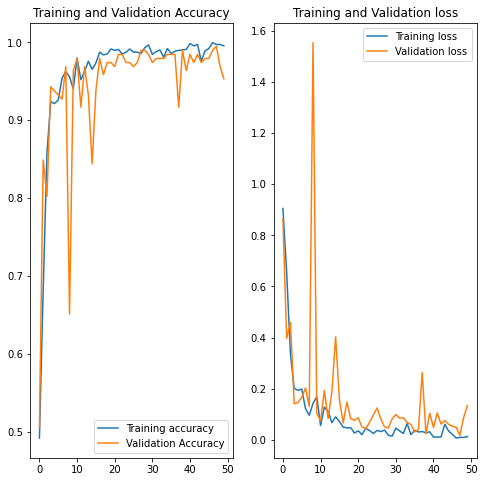

In [41]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS),val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss, label="Validation loss")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

first image to predict
actual label is Potato___Early_blight
1/1 [==============================] - 0s 440ms/step
predicted label is Potato___Early_blight


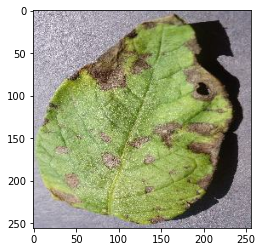

In [54]:
# prediction
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label is",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label is",class_names[np.argmax(batch_prediction[0])])

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


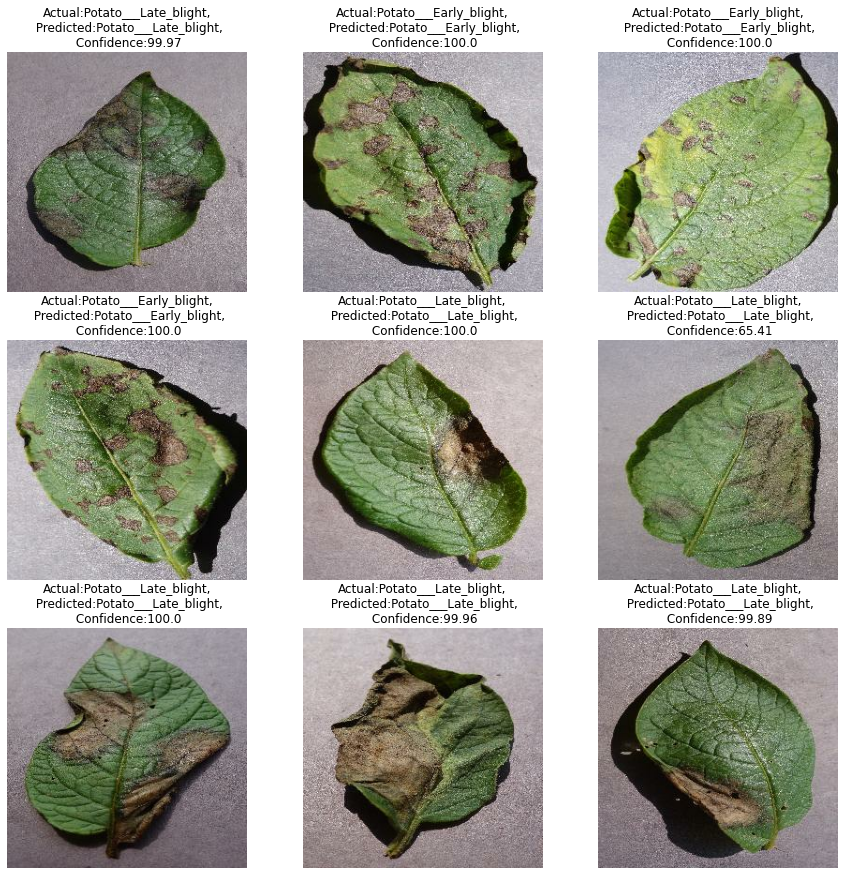

In [62]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis('off')
    

In [63]:
model_version=1
model.save(f"../models/{model_version}")
           

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [64]:
# to autoincrement models
'''
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version})
'''

'\nimport os\nmodel_version=max([int(i) for i in os.listdir("../models")+[0]])+1\nmodel.save(f"../models/{model_version})\n'